**This is a Python implementation of Randomized Smoothing applied to a computer vision example using PyTorch and ResNet-18 on the CIFAR-10 dataset.**
**The code applies Gaussian noise to the input images and uses majority voting to determine the final classification.**



***The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.***

***ResNet-18 is a convolutional neural network that is 18 layers deep. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224.***

# Steps in the Code
1.   Load CIFAR-10 Dataset: Use PyTorch's torchvision.datasets.
2.   Load Pretrained Model: Use torchvision.models.resnet18.
3.   Apply Randomized Smoothing:
  1.   Add Gaussian noise to an image multiple times.
  2.   Run the perturbed images through the model.
  3.   Use majority voting to determine the final class.

Randomized Smoothing Function (returns smoothed label + noisy images)
,Visualization Function (takes noisy images & displays them)








In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
from collections import Counter

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet requires 224x224 input
    transforms.ToTensor()
])

test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)



100%|██████████| 170M/170M [00:02<00:00, 77.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [2]:
# Load pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)
model.eval().to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
def randomized_smoothing(image, model, num_samples=100, noise_std=0.1):
    """
    Apply Randomized Smoothing to generate multiple noisy samples and classify them.

    Args:
        image (torch.Tensor): Input image tensor of shape (1, 3, 224, 224)
        model (torch.nn.Module): Pretrained classifier
        num_samples (int): Number of noisy samples
        noise_std (float): Standard deviation of Gaussian noise

    Returns:
        int: Smoothed classification label
        list: List of noisy images (for visualization)
    """
    image = image.to(device)
    preds = []
    noisy_images = []

    for _ in range(num_samples):
        noisy_image = image + torch.randn_like(image) * noise_std  # Add Gaussian noise
        noisy_image = torch.clamp(noisy_image, 0, 1)  # Keep pixel values in valid range

        noisy_images.append(noisy_image.cpu().squeeze().permute(1, 2, 0).numpy())  # Save for visualization

        with torch.no_grad():
            output = model(noisy_image)
            predicted_label = torch.argmax(output, dim=1).item()
            preds.append(predicted_label)

    # Majority voting for final label
    final_label = Counter(preds).most_common(1)[0][0]

    return final_label, noisy_images


In [4]:
import matplotlib.pyplot as plt
def visualize_noisy_images(noisy_images, num_images=15):
    """
    Display noisy images in a grid.

    Args:
        noisy_images (list): List of noisy images
        num_images (int): Number of noisy images to display
    """
    fig, axes = plt.subplots(3, 5, figsize=(10, 6))
    axes = axes.flatten()

    for i in range(num_images):  # Show first 'num_images' noisy images
        axes[i].imshow(noisy_images[i])
        axes[i].axis("off")

    plt.suptitle("Randomized Smoothing - Noisy Samples")
    plt.show()


True Label: 7, Smoothed Prediction: 279


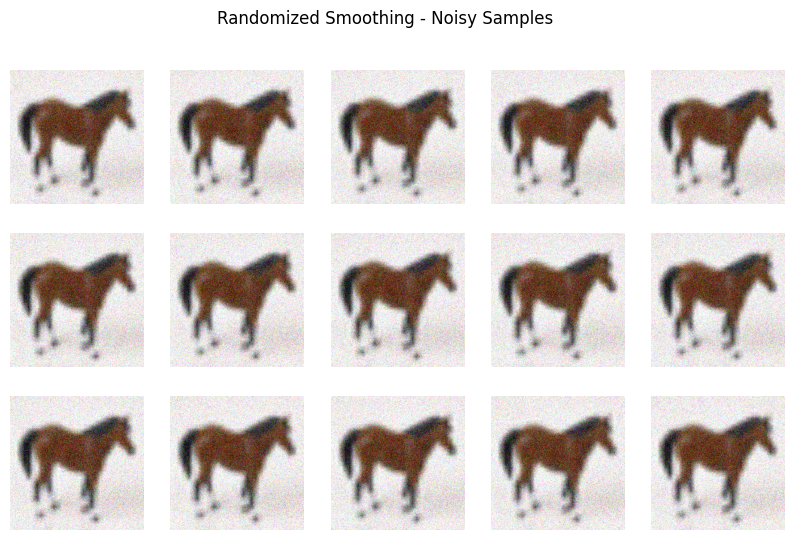

In [5]:
# Get one sample from CIFAR-10
image, label = next(iter(test_loader))

# Apply Randomized Smoothing
smoothed_label, noisy_images = randomized_smoothing(image, model, num_samples=100, noise_std=0.1)

# Print results
print(f"True Label: {label.item()}, Smoothed Prediction: {smoothed_label}")

# Visualize noisy samples
visualize_noisy_images(noisy_images, num_images=15)
